In [1]:
import vtk
import matplotlib.pyplot as plt
import numpy as np
import os
from vtk import vtkXMLUnstructuredGridReader
from vtk.util.numpy_support import vtk_to_numpy
import pygmt
import geopy
import pyproj
from geopy.distance import geodesic
from geopy.distance import distance
geodesic = pyproj.Geod(ellps='WGS84')

from scipy.spatial import KDTree
from mpl_toolkits.axes_grid1 import make_axes_locatable
os.chdir("../slab2_worldbuilder_generation/scripts_for_wb_files/")
import profile_maker

os.chdir("../../postprocessing_scripts/")
import parallel_curves
import slab_hydration

os.chdir("../main_figures/")

In [2]:
def cartesian_to_spherical(x, y, z):
    """
    Takes an x, y, z and converts it to spherical coordinates. Returns r, theta, phi
    """
    r = np.sqrt(x**2 + y**2 + z**2)
    theta = 90 - np.rad2deg( np.arccos( z / (np.sqrt(x**2 + y**2 + z**2)) ) )
    phi =  np.sign(y) * np.rad2deg(np.arccos( x / np.sqrt(x**2 + y**2) ))
    phi[np.where(phi < 0)] = phi[np.where(phi < 0)] + 360
    phi[np.where(phi == 0)] = 180
    
    return r, phi, theta

def spherical_to_global_cartesian(r, phi, theta):
    """
    Takes spherical coordinates r, theta, and phi and converts to Cartesian coordinates.
    Returns x, y, z
    """
    x = r * np.sin(np.deg2rad(90 - theta)) * np.cos(np.deg2rad(phi))
    y = r * np.sin(np.deg2rad(90 - theta)) * np.sin(np.deg2rad(phi))
    z = r * np.cos(np.deg2rad(90 - theta))
    
    return x, y, z

In [3]:
data_dir_path = "../data/"
coast_arr = np.loadtxt(fname=data_dir_path + "coastline.txt")
slab2_cont = np.loadtxt(fname=data_dir_path + "slab2_tonga.in", delimiter='\t', comments='>', dtype=float)
AUS_TVZ = np.loadtxt(fname=data_dir_path + "DEP_zealith2/AUS_lith50.xyd", comments='>')

slab2_depth = np.loadtxt(fname=data_dir_path + "combined_slab2.txt")
slab2_contours = np.array(sorted(slab2_cont, key=lambda x: x[1], reverse=True))
trench_contour = data = np.loadtxt(fname=data_dir_path + "trench_contour.csv", delimiter=',')[0:270]

HIK_plateau = np.loadtxt(data_dir_path + "Hikurangi_Plateau_wgs84.csv", delimiter=',', skiprows=1)
HIK_plateau = np.delete(HIK_plateau, [83, -1], axis=0)
for i in range(len(HIK_plateau)):
    if HIK_plateau[:, 0][i] < 0:
        HIK_plateau[:, 0][i] += 360

depth_contour = -20
number_of_profiles = 20
profile_spacing = 5
lon_spacing = 0.1
lat_spacing = 0.1
max_distance_point = 5
regional_lon = [170, 190]
regional_lat_depth = [-41.4, -33]
regional_lat_trench = [-41, -33]
profiles_output_dir = 'dehydration_mapview_profiles/'

draw_profiles = True

if draw_profiles:
    profile_maker.profile_generator(slab2_depth, trench_contour, profiles_output_dir, depth_contour, number_of_profiles - 1, profile_spacing, regional_lon, regional_lat_trench, \
                                    lon_spacing, lat_spacing, max_distance_point, 90, 'East', use_trench=True)

## This cell loads in the ASPECT output

In [6]:
sol_dir_path = "../ASPECT_models/5e20_10kmweak_dry/solution/"
solutions = np.sort(os.listdir( sol_dir_path ))

t_step = 0
if 'pos_solution' in locals():
    del pos_solution, litho_total, crust_total, T_raw_total, P_raw_total, TVZ_total, mantle_total

for soln in solutions:
    if soln[-4:-1] == '.vt' and soln[9:14] == str(t_step).zfill(5):
        
        file_path = os.path.join(sol_dir_path, soln)
        reader = vtkXMLUnstructuredGridReader()
        reader.SetFileName(file_path)
        reader.Update()
        data = reader.GetOutput()
        points = data.GetPoints()
        x = vtk_to_numpy(points.GetData())
        litho = vtk_to_numpy(data.GetPointData().GetArray('Base_Subducting'))
        mantle = vtk_to_numpy(data.GetPointData().GetArray('Upper_Mantle'))
        crust = vtk_to_numpy(data.GetPointData().GetArray('Crust'))
        TVZ = vtk_to_numpy(data.GetPointData().GetArray('TVZ'))
        T_raw = vtk_to_numpy(data.GetPointData().GetArray('T'))
        P_raw = vtk_to_numpy(data.GetPointData().GetArray('p'))

        if 'pos_solution' in locals():
            pos_solution = np.concatenate( (pos_solution, x) )
            litho_total = np.concatenate( (litho_total, litho) )
            mantle_total = np.concatenate( (mantle_total, mantle) )
            TVZ_total = np.concatenate( (TVZ_total, TVZ) )
            T_raw_total = np.concatenate( (T_raw_total, T_raw) )
            P_raw_total = np.concatenate( (P_raw_total, P_raw) )
            crust_total = np.concatenate( (crust_total, crust) )
        else:
            pos_solution = x
            litho_total = litho
            mantle_total = mantle
            TVZ_total = TVZ
            T_raw_total = T_raw
            P_raw_total = P_raw
            crust_total = crust

slab_indices = np.where( (litho_total >= 0.5) | (crust_total >= 0.5) )
mantle_indices = np.where( (mantle_total >= 0.5) )
slab_x = pos_solution[:, 0][slab_indices]
slab_y = pos_solution[:, 1][slab_indices]
slab_z = pos_solution[:, 2][slab_indices]
slab_P = P_raw_total[slab_indices]
slab_T = T_raw_total[slab_indices]
ASPECT_slab_r, ASPECT_slab_phi, ASPECT_slab_theta = cartesian_to_spherical(slab_x, slab_y, slab_z)

mantle_x = pos_solution[:, 0][mantle_indices]
mantle_y = pos_solution[:, 1][mantle_indices]
mantle_z = pos_solution[:, 2][mantle_indices]
mantle_P = P_raw_total[mantle_indices]
mantle_T = T_raw_total[mantle_indices]

tree_unstructured = KDTree(np.c_[slab_x, slab_y, slab_z])

# Iterate over ALL Profiles

In [7]:
import time
start_time = time.time()

# Define the constants
cutoff_distance = 2.5e3
radius_array = np.linspace(6371e3, 5871e3, 401)
base_depth = 0

H2O_LR_poly_sediment = np.array([-2.03283, 10.8186, -21.2119, 18.3351, -6.48711, 8.32459])
H2O_c_sat_poly_sediment = np.array([-0.150662, 0.301807, 1.01867])
H2O_Td_poly_sediment = np.array([2.83277, -24.7593, 85.9090, 524.898])

sediment_density = 2300
sediment_depth_range = np.array([0, 2])
sediment_max_hydration = 3.3 / 100

H2O_LR_poly_MORB = np.array([-1.78177, 7.50871, -10.4840, 5.19725, 7.96365])
H2O_c_sat_poly_MORB = np.array([0.0102725, -0.115390, 0.324452, 1.41588])
H2O_Td_poly_MORB = np.array([-3.81280, 22.7809, 638.049])

MORB_density = 2900
MORB_depth_range = np.array([2, 6])
MORB_max_hydration = 3.0 / 100

H2O_LR_poly_gabbro = np.array([-1.81745, 7.67198, -10.8507, 5.09329, 8.14519])
H2O_c_sat_poly_gabbro = np.array([-0.0176673, 0.0893044, 1.52732])
H2O_Td_poly_gabbro = np.array([-1.72277, 20.5898, 637.517])

gabbro_density = 3000
gabbro_depth_range = np.array([6, 11])
gabbro_max_hydration = 0.8 / 100

H2O_LR_poly_peridotite = np.array([-19.0609, 168.983, -630.032, 1281.84, -1543.14, 1111.88, -459.142, 95.4143, 1.97246])
H2O_c_sat_poly_peridotite = np.array([0.00115628, 2.42179])
H2O_Td_poly_peridotite = np.array([-15.4627, 94.9716, 636.603])

peridotite_density = 3300
peridotite_depth_range = np.array([11, 16])
peridotite_max_hydration = 2 / 100

all_lat_points = np.empty(0)
all_lon_points = np.empty(0)
all_flux_points = np.empty(0)
all_sediment_points = np.empty(0)
all_MORB_points = np.empty(0)
all_gabbro_points = np.empty(0)
all_peridotite_points = np.empty(0)

# Iterate over all the profiles
profile_number = 0
for file in np.sort(os.listdir(profiles_output_dir + '/geographic')):
    
    # Load in all the profiles
    profile_file = np.loadtxt(fname=profiles_output_dir + '/geographic/' + file)
    
    # Create the coordinates for the terminii of the slice
    lon_lat_slice = np.array([[profile_file[0][0], profile_file[0][1]], \
                              [profile_file[-1][0], profile_file[-1][1]]])
    
    # Draw the profile with a specific interval
    profile = pygmt.project(center=[lon_lat_slice[0][0], lon_lat_slice[0][1]], endpoint=[lon_lat_slice[1][0], lon_lat_slice[1][1]], generate=1e3/1e3, unit=True).to_numpy()
    prof_lon = profile[:, 0]
    prof_lat = profile[:, 1]
    prof_dist = profile[:, 2]
    prof_lon[np.where(prof_lon < 0)] = prof_lon[np.where(prof_lon < 0)] + 360
    prof_lon[np.where(prof_lon == 0)] = 180
    
    if prof_lat[0] >= -36:
        sediment_depth_range = np.array([0, 2])
        MORB_depth_range = np.array([2, 5])
        gabbro_depth_range = np.array([5, 9])
        peridotite_depth_range = np.array([9, 16])
    slab_top_depth = np.empty(0)
    slab_top_dist = np.empty(0)
                
    slab_depth_vals = np.empty(0)
    slab_dist_vals = np.empty(0)
    slab_T_vals = np.empty(0)
    slab_P_vals = np.empty(0)

    # Extract the location of all the slab P-T values within the slice, and the slab top
    for i in range(len(prof_lon)):
        reached_surface = False
        for j in range(len(radius_array)):              
            prof_x, prof_y, prof_z = spherical_to_global_cartesian(radius_array[j], prof_lon[i], prof_lat[i])

            dd, slab_idx = tree_unstructured.query([prof_x, prof_y, prof_z], k=1)
            if dd <= cutoff_distance:
                
                if not reached_surface:
                    slab_top_dist = np.append(slab_top_dist, prof_dist[i])
                    slab_top_depth = np.append(slab_top_depth, (6371e3 - ASPECT_slab_r[slab_idx]) / 1e3 )
                    reached_surface = True
                
                slab_dist_vals = np.append(slab_dist_vals, prof_dist[i])
                slab_depth_vals = np.append(slab_depth_vals, (6371e3 - ASPECT_slab_r[slab_idx]) / 1e3 )
                slab_T_vals = np.append(slab_T_vals, slab_T[slab_idx])
                slab_P_vals = np.append(slab_P_vals, slab_P[slab_idx])
                
    litho_thickness = 16
    line_spacing = 0.25
    number_of_lines = int(litho_thickness / line_spacing)
    parallel_slab_dist = np.zeros(number_of_lines, dtype=object)
    parallel_slab_depth = np.zeros(number_of_lines, dtype=object)

    # Interpolate the slab-top points to make a smooth curve
    p_coeff = np.polyfit(slab_top_dist, slab_top_depth, 5)
    full_interp_slab_top = 0
    interp_dxy = 0.25
    full_interp_slab_dist = np.arange(np.min(slab_top_dist), np.max(slab_top_dist) + interp_dxy, interp_dxy)
    for p in range(len(p_coeff)):
        full_interp_slab_top += p_coeff[p] * full_interp_slab_dist**(len(p_coeff) - 1 - p)

    # Draw parallel lines to the slab top curve
    for i in range(number_of_lines):
        res = parallel_curves.parallel_curves(full_interp_slab_dist, full_interp_slab_top, d=base_depth + line_spacing * (i), make_plot=False, flag1=False)
        parallel_slab_dist[i] = res['x_inner']
        parallel_slab_depth[i] = res['y_inner']

    # Create a KDTree of the slab points in the profile
    slab_tree = KDTree(np.c_[slab_dist_vals, slab_depth_vals])
    
    profile_pressure = np.zeros(len(parallel_slab_dist), dtype=object)
    profile_temperature = np.zeros(len(parallel_slab_dist), dtype=object)

    # Extract the slab P-T along each of the parallel profiles
    for i in range(len(parallel_slab_dist)):
        profile_pressure[i] = np.zeros(len(parallel_slab_dist[i]))
        profile_temperature[i] = np.zeros(len(parallel_slab_dist[i]))

        for j in range(len(parallel_slab_dist[i])):
            dd, ii = slab_tree.query([parallel_slab_dist[i][j], parallel_slab_depth[i][j]], k=1)
            profile_pressure[i][j] = slab_P_vals[ii]
            profile_temperature[i][j] = slab_T_vals[ii]

    # Calculate the water content and dehydration along each profile
    hydration_container = np.zeros(number_of_lines, dtype=object)
    dehydration_container = np.zeros(number_of_lines, dtype=object)

    sediment_hydration = np.zeros(number_of_lines, dtype=object)
    sediment_dehydration = np.zeros(number_of_lines, dtype=object)

    gabbro_hydration = np.zeros(number_of_lines, dtype=object)
    gabbro_dehydration = np.zeros(number_of_lines, dtype=object)

    MORB_hydration = np.zeros(number_of_lines, dtype=object)
    MORB_dehydration= np.zeros(number_of_lines, dtype=object)

    peridotite_hydration = np.zeros(number_of_lines, dtype=object)
    peridotite_dehydration = np.zeros(number_of_lines, dtype=object)
    ############################################################### SEDIMENTS ##########################################################################
    hydration_container, dehydration_container = slab_hydration.dehydration_func(H2O_LR_poly_sediment, H2O_c_sat_poly_sediment, H2O_Td_poly_sediment, \
                                                                                 sediment_density, profile_pressure, profile_temperature, \
                                                                                 sediment_max_hydration, hydration_container, dehydration_container, \
                                                                                 parallel_slab_dist, sediment_depth_range, line_spacing, sediment=True)

    sediment_hydration, sediment_dehydration = slab_hydration.dehydration_func(H2O_LR_poly_sediment, H2O_c_sat_poly_sediment, H2O_Td_poly_sediment, \
                                                                               sediment_density, profile_pressure, profile_temperature, \
                                                                               sediment_max_hydration, sediment_hydration, sediment_dehydration, \
                                                                               parallel_slab_dist, sediment_depth_range, line_spacing, sediment=True)
    ############################################################### MORB ##########################################################################
    hydration_container, dehydration_container = slab_hydration.dehydration_func(H2O_LR_poly_MORB, H2O_c_sat_poly_MORB, H2O_Td_poly_MORB, \
                                                                                 MORB_density, profile_pressure, profile_temperature, \
                                                                                 MORB_max_hydration, hydration_container, dehydration_container, \
                                                                                 parallel_slab_dist, MORB_depth_range, line_spacing, sediment=False)

    MORB_hydration, MORB_dehydration = slab_hydration.dehydration_func(H2O_LR_poly_MORB, H2O_c_sat_poly_MORB, H2O_Td_poly_MORB, \
                                                                       MORB_density, profile_pressure, profile_temperature, \
                                                                       MORB_max_hydration, MORB_hydration, MORB_dehydration, \
                                                                       parallel_slab_dist, MORB_depth_range, line_spacing, sediment=False)
    ############################################################### GABBRO ##########################################################################
    hydration_container, dehydration_container = slab_hydration.dehydration_func(H2O_LR_poly_gabbro, H2O_c_sat_poly_gabbro, H2O_Td_poly_gabbro, \
                                                                                 gabbro_density, profile_pressure, profile_temperature, \
                                                                                 gabbro_max_hydration, hydration_container, dehydration_container, \
                                                                                 parallel_slab_dist, gabbro_depth_range, line_spacing, sediment=False)

    gabbro_hydration, gabbro_dehydration = slab_hydration.dehydration_func(H2O_LR_poly_gabbro, H2O_c_sat_poly_gabbro, H2O_Td_poly_gabbro, \
                                                                           gabbro_density, profile_pressure, profile_temperature, \
                                                                           gabbro_max_hydration, gabbro_hydration, gabbro_dehydration, \
                                                                           parallel_slab_dist, gabbro_depth_range, line_spacing, sediment=False)
    ############################################################### PERIDOTITE ##########################################################################
    hydration_container, dehydration_container = slab_hydration.dehydration_func(H2O_LR_poly_peridotite, H2O_c_sat_poly_peridotite, H2O_Td_poly_peridotite, \
                                                                                 peridotite_density, profile_pressure, profile_temperature, \
                                                                                 peridotite_max_hydration, hydration_container, dehydration_container, \
                                                                                 parallel_slab_dist, peridotite_depth_range, line_spacing, sediment=False)

    peridotite_hydration, peridotite_dehydration = slab_hydration.dehydration_func(H2O_LR_poly_peridotite, H2O_c_sat_poly_peridotite, H2O_Td_poly_peridotite, \
                                                                                   peridotite_density, profile_pressure, profile_temperature, \
                                                                                   peridotite_max_hydration, peridotite_hydration, peridotite_dehydration, \
                                                                                   parallel_slab_dist, peridotite_depth_range, line_spacing, sediment=False)
    ############################################################### END HYDRATION CALC ##########################################################################   
    
    for i in range(len(sediment_hydration)):
        if np.any(sediment_hydration[i]):
            sediment_hydration[i] = sediment_hydration[i]
            sediment_dehydration[i] = sediment_dehydration[i]
        else:
            sediment_hydration[i] = np.zeros(len(parallel_slab_dist[0]))
            sediment_dehydration[i] = np.zeros(len(parallel_slab_dist[0]))

    for i in range(len(gabbro_hydration)):
        if np.any(gabbro_hydration[i]):
            gabbro_hydration[i] = gabbro_hydration[i]
            gabbro_dehydration[i] = gabbro_dehydration[i]
        else:
            gabbro_hydration[i] = np.zeros(len(parallel_slab_dist[0]))
            gabbro_dehydration[i] = np.zeros(len(parallel_slab_dist[0]))

    for i in range(len(MORB_hydration)):
        if np.any(MORB_hydration[i]):
            MORB_hydration[i] = MORB_hydration[i]
            MORB_dehydration[i] = MORB_dehydration[i]
        else:
            MORB_hydration[i] = np.zeros(len(parallel_slab_dist[0]))
            MORB_dehydration[i] = np.zeros(len(parallel_slab_dist[0]))

    for i in range(len(peridotite_hydration)):
        if np.any(peridotite_hydration[i]):
            peridotite_hydration[i] = peridotite_hydration[i]
            peridotite_dehydration[i] = peridotite_dehydration[i]
        else:
            peridotite_hydration[i] = np.zeros(len(parallel_slab_dist[0]))
            peridotite_dehydration[i] = np.zeros(len(parallel_slab_dist[0]))
    
    # Calculate the surface water flux (vertical integration)
    surface_slab_water_flux = slab_hydration.vertical_surface_water_flux(parallel_slab_dist, parallel_slab_depth, dehydration_container, line_spacing)
    surface_slab_sediment_flux = slab_hydration.vertical_surface_water_flux(parallel_slab_dist, parallel_slab_depth, sediment_dehydration, line_spacing)
    surface_slab_MORB_flux = slab_hydration.vertical_surface_water_flux(parallel_slab_dist, parallel_slab_depth, MORB_dehydration, line_spacing)
    surface_slab_gabbro_flux = slab_hydration.vertical_surface_water_flux(parallel_slab_dist, parallel_slab_depth, gabbro_dehydration, line_spacing)
    surface_slab_peridotite_flux = slab_hydration.vertical_surface_water_flux(parallel_slab_dist, parallel_slab_depth, peridotite_dehydration, line_spacing)

    # Bin the flux into 1km bins
    bin_size = 10
    surface_slab_flux_x = np.arange(0, np.max(parallel_slab_dist[0]) + bin_size, bin_size)
    bin_peridotite_slab_flux = np.zeros(len(surface_slab_flux_x))
    bin_sediment_slab_flux = np.zeros(len(surface_slab_flux_x))
    bin_gabbro_slab_flux = np.zeros(len(surface_slab_flux_x))
    bin_MORB_slab_flux = np.zeros(len(surface_slab_flux_x))
    bin_total_slab_flux = np.zeros(len(surface_slab_flux_x))
    for i in range(len(surface_slab_flux_x) - 1):
        bin_index = np.where( (parallel_slab_dist[0] >= surface_slab_flux_x[i]) & (parallel_slab_dist[0] <= surface_slab_flux_x[i+1]) )
        bin_peridotite_slab_flux[i] = np.trapz(surface_slab_peridotite_flux[bin_index], dx=interp_dxy)
        bin_sediment_slab_flux[i] = np.trapz(surface_slab_sediment_flux[bin_index], dx=interp_dxy)
        bin_gabbro_slab_flux[i] = np.trapz(surface_slab_gabbro_flux[bin_index], dx=interp_dxy)
        bin_MORB_slab_flux[i] = np.trapz(surface_slab_MORB_flux[bin_index], dx=interp_dxy)
        bin_total_slab_flux[i] = np.trapz(surface_slab_water_flux[bin_index], dx=interp_dxy)

    cutoff_val = 0
    set_val = 0
    bin_total_slab_flux[np.where(bin_total_slab_flux <= cutoff_val)] = set_val
    bin_sediment_slab_flux[np.where(bin_sediment_slab_flux <= cutoff_val)] = set_val
    bin_MORB_slab_flux[np.where(bin_MORB_slab_flux <= cutoff_val)] = set_val
    bin_gabbro_slab_flux[np.where(bin_gabbro_slab_flux <= cutoff_val)] = set_val
    bin_peridotite_slab_flux[np.where(bin_peridotite_slab_flux <= cutoff_val)] = set_val
    
    # Create a higher resolution profile and convert the profiles back to lon/lat
    highres_profile = pygmt.project(center=[lon_lat_slice[0][0], lon_lat_slice[0][1]], endpoint=[lon_lat_slice[1][0], lon_lat_slice[1][1]], generate=bin_size, unit=True).to_numpy()
    highres_prof_lon = highres_profile[:, 0]
    highres_prof_lat = highres_profile[:, 1]
    highres_prof_dist = highres_profile[:, 2]
    highres_prof_lon[np.where(highres_prof_lon < 0)] = highres_prof_lon[np.where(highres_prof_lon < 0)] + 360
    highres_prof_lon[np.where(highres_prof_lon == 0)] = 180
    
    for i in range(len(surface_slab_flux_x)):
        lonlat_index = np.abs((highres_prof_dist - surface_slab_flux_x[i])).argmin()
        all_lat_points = np.append(all_lat_points, highres_prof_lat[lonlat_index])
        all_lon_points = np.append(all_lon_points, highres_prof_lon[lonlat_index])
        all_flux_points = np.append(all_flux_points, bin_total_slab_flux[i])
        all_sediment_points = np.append(all_sediment_points, bin_sediment_slab_flux[i])
        all_MORB_points = np.append(all_MORB_points, bin_MORB_slab_flux[i])
        all_gabbro_points = np.append(all_gabbro_points, bin_gabbro_slab_flux[i])
        all_peridotite_points = np.append(all_peridotite_points, bin_peridotite_slab_flux[i])
        
    profile_number += 1
    if profile_number % 5 == 0:
        print(str(profile_number) + " of " + str(number_of_profiles) + " profiles. \n")

print("--- %s seconds ---" % (time.time() - start_time))

/Users/danieldouglas/scripts_and_data_for_nz_publication/postprocessing_scripts/slab_hydration.py:56: RuntimeWarning: overflow encountered in exp
  partition_coeff = c_sat_val * np.exp(LR_val * (1/temperature - 1/Td_val))
/Users/danieldouglas/scripts_and_data_for_nz_publication/postprocessing_scripts/slab_hydration.py:56: RuntimeWarning: overflow encountered in exp
  partition_coeff = c_sat_val * np.exp(LR_val * (1/temperature - 1/Td_val))


5 of 20 profiles. 

10 of 20 profiles. 

15 of 20 profiles. 



/Users/danieldouglas/scripts_and_data_for_nz_publication/postprocessing_scripts/slab_hydration.py:56: RuntimeWarning: overflow encountered in exp
  partition_coeff = c_sat_val * np.exp(LR_val * (1/temperature - 1/Td_val))
/Users/danieldouglas/scripts_and_data_for_nz_publication/postprocessing_scripts/slab_hydration.py:56: RuntimeWarning: overflow encountered in exp
  partition_coeff = c_sat_val * np.exp(LR_val * (1/temperature - 1/Td_val))


--- 643.990042924881 seconds ---


In [8]:
rounding = 2
model_contour_values = np.linspace(6361e3, 5861e3, 101)
padding = 1e3
cutoff_lats = np.array([-41, -26.5])
cutoff_lons = np.array([160, 184])
model_depth_contour_lats = np.zeros(len(model_contour_values), dtype=object)
model_depth_contour_lons = np.zeros(len(model_contour_values), dtype=object)
model_depth_contour_depths = np.zeros(len(model_contour_values), dtype=object)
for i in range(len(model_contour_values)):
    depth_slice_ind = np.where( (ASPECT_slab_r <= model_contour_values[i] + padding) & (ASPECT_slab_r >= model_contour_values[i] - padding) & \
                                (ASPECT_slab_theta <= np.max(cutoff_lats)) & (ASPECT_slab_theta >= np.min(cutoff_lats)) & \
                                (ASPECT_slab_phi <= np.max(cutoff_lons)) )
    
    lon_at_depth_slice = ASPECT_slab_phi[depth_slice_ind]
    lat_at_depth_slice = ASPECT_slab_theta[depth_slice_ind]
    
    lat_values = np.empty(0)
    lon_values = np.empty(0)
    depth_values = np.empty(0)
    for j in range(len(lat_at_depth_slice)):
        if np.round(lat_at_depth_slice[j], rounding) not in lat_values:
            
            lat_indices = np.where(np.round(lat_at_depth_slice, rounding) == np.round(lat_at_depth_slice[j], rounding) )
            lat_values = np.append(lat_values, np.round(lat_at_depth_slice[j], rounding))
            lon_values = np.append(lon_values, np.min(lon_at_depth_slice[lat_indices]))
            
    model_depth_contour_lats[i] = lat_values[lat_values.argsort()]
    model_depth_contour_lons[i] = lon_values[lat_values.argsort()]
    model_depth_contour_depths[i] = np.ones(len(lat_values)) * (6371e3 - model_contour_values[i])

all_x_points, all_y_points, all_z_points = spherical_to_global_cartesian(6371e3, all_lon_points, all_lat_points)
slab_contour_tree = KDTree(np.c_[all_x_points, all_y_points, all_z_points])

dehydration_flux_values = np.zeros(len(model_depth_contour_lons), dtype=object)

for i in range(len(dehydration_flux_values)):
    max_allow_dist = 2.5e3
    contour_x, contour_y, contour_z = spherical_to_global_cartesian(6371e3, model_depth_contour_lons[i], model_depth_contour_lats[i])
    this_contour_flux_values = np.zeros(len(contour_x))
    for j in range(len(contour_x)):
        dd, ii = slab_contour_tree.query([contour_x[j], contour_y[j], contour_z[j]], k=10)
        flux_weights = np.zeros(len(dd))
        flux_vals = np.zeros(len(dd))
        if i == 0:
            max_allow_dist = 100e3
        for k in range(len(dd)):
            if dd[k] <= max_allow_dist:
                if dd[k] <= 1e-10:
                    flux_weights[k] = 1e10
                    flux_vals[k] = all_flux_points[ii[k]]
                else:
                    flux_weights[k] = 1 / dd[k]
                    flux_vals[k] = all_flux_points[ii[k]]
                    
        if np.sum(flux_weights) == 0:
            flux_weights += 1
        this_contour_flux_values[j] = np.average(flux_vals, weights=flux_weights)
            
    dehydration_flux_values[i] = this_contour_flux_values

for i in range(len(dehydration_flux_values)):
    if np.max(dehydration_flux_values[i]) != 0:
        nonzero_ind = np.where(dehydration_flux_values[i] > 0)
        which_profile_index = 0
        for j in range(len(dehydration_flux_values[i])):
            if len(nonzero_ind[0]) == 1:
                dehydration_flux_values[i][j] = dehydration_flux_values[i][nonzero_ind[0]]
                
            else:
                for k in range(len(nonzero_ind[0]) - 1):
                    if j <= nonzero_ind[0][k + 1] and j >= nonzero_ind[0][k]:
                        first_val = dehydration_flux_values[i][nonzero_ind[0][k]]
                        second_val = dehydration_flux_values[i][nonzero_ind[0][k + 1]]
                        dehydration_flux_values[i][j] = first_val + ( (j - nonzero_ind[0][k]) / (nonzero_ind[0][k + 1] - nonzero_ind[0][k])) * (second_val - first_val)
                        
                    elif j < nonzero_ind[0][0]:
                        # first_val = dehydration_flux_values[i][0]
                        first_val = 0
                        second_val = dehydration_flux_values[i][nonzero_ind[0][0]]
                        dehydration_flux_values[i][j] = first_val + ( (j) / (nonzero_ind[0][0])) * (second_val - first_val)
                        
                    elif j > nonzero_ind[0][-1]:
                        first_val = dehydration_flux_values[i][nonzero_ind[0][-1]]
                        second_val = 0
                        second_val = dehydration_flux_values[i][-1]
                        dehydration_flux_values[i][j] = first_val + ( (j - nonzero_ind[0][-1]) / (len(dehydration_flux_values[i]) - 1 - nonzero_ind[0][-1]) * \
                                                                      (second_val - first_val) )

In [10]:
pygmt_lons = np.empty(0)
pygmt_lats = np.empty(0)
pygmt_flux = np.empty(0)

for i in range(len(model_depth_contour_lons)):
    pygmt_lons = np.append(pygmt_lons, model_depth_contour_lons[i])
    pygmt_lats = np.append(pygmt_lats, model_depth_contour_lats[i])
    pygmt_flux = np.append(pygmt_flux, dehydration_flux_values[i])

import pandas as pd
df_original = pd.DataFrame({'LON':pygmt_lons,
                            'LAT':pygmt_lats,
                            'FLUX':pygmt_flux / 10e3 * 0.05})

plateau_leading_edge = np.loadtxt(fname=data_dir_path + "plateau_line.txt")
volcanoes = np.loadtxt(fname=data_dir_path + "volcanoes.txt")

surface [WARNING]: 15 unusable points were supplied; these will be ignored.
surface [WARNING]: You should have pre-processed the data with block-mean, -median, or -mode.
surface [WARNING]: Check that previous processing steps write results with enough decimals.
surface [WARNING]: Possibly some data were half-way between nodes and subject to IEEE 754 rounding.
gmtset [ERROR]: Pen name None not recognized!
gmtset [WARNING]: Representation of pen width (None) not recognized. Using default.


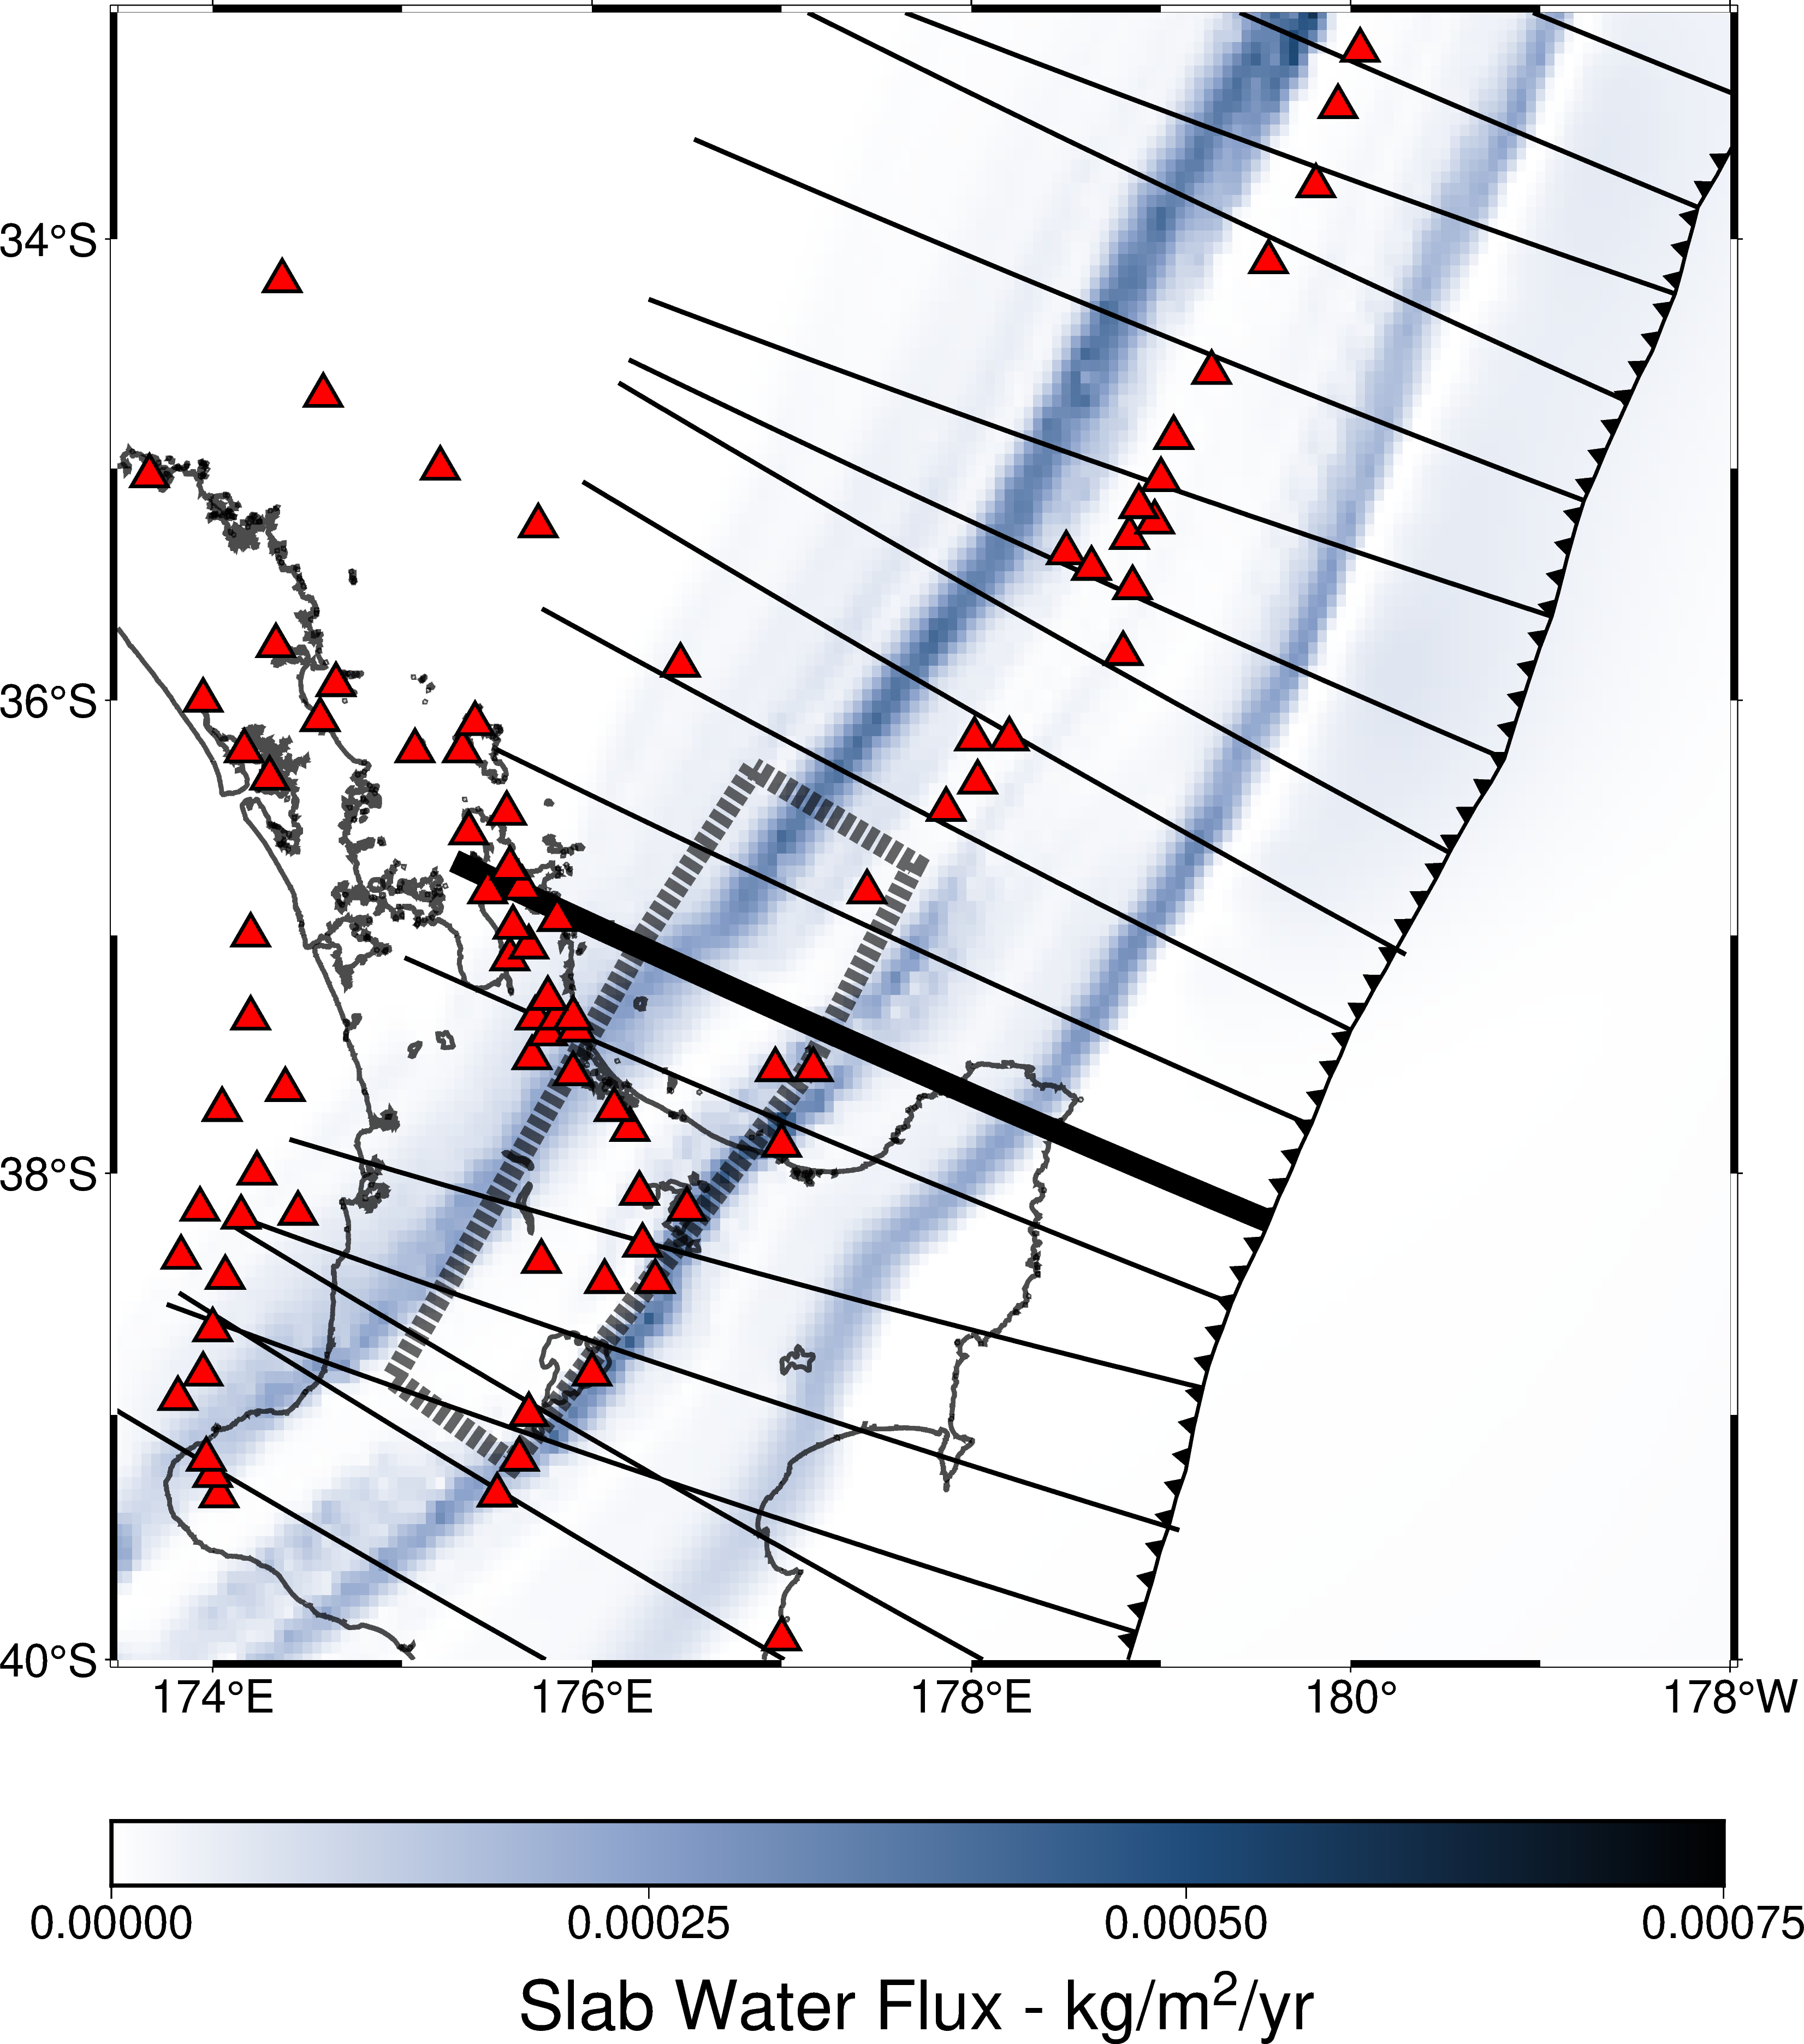

In [12]:
plot_region = [173.5, 182, -40, -33]
df = pygmt.blockmean(data=df_original, region=plot_region, spacing='0.1+e')
flux_grid = pygmt.surface(data=df, spacing=0.05, region=plot_region, tension=0.1, lower=0)

fig = pygmt.Figure()
pygmt.config(FONT_LABEL='30p', MAP_LABEL_OFFSET='0.5', MAP_TICK_PEN_PRIMARY=None, FONT_ANNOT_PRIMARY='20p')
fig.basemap(region=plot_region, projection="M25c", frame=["af"])#, "+tGeologic Harzard Map"])
pygmt.makecpt(cmap="oslo", series=[0, 0.00075, 0.00025], continuous=True, reverse=True)

fig.grdimage(grid=flux_grid, nan_transparent=True)
fig.colorbar(position="JBC+o-0.1c/2.5c+w25c/1c+h", frame=["0.00025", "x+lSlab Water Flux - kg/m@+2@+/yr"])

fig.coast(
    shorelines="2p,black",
    transparency=30
)

fig.plot(x=AUS_TVZ[:, 0], y=AUS_TVZ[:, 1], fill=None, transparency=40, pen='10p,black,4_2:2p')
fig.plot(x=trench_contour[:, 0], y=trench_contour[:, 1], pen="1.5p", style="f0.5c/0.3c+l+t+o0.3c+p", fill='black')

for i, file in enumerate(np.sort(os.listdir(profiles_output_dir + '/geographic'))):
    profile_file = np.loadtxt(fname=profiles_output_dir + '/geographic/' + file)
    if i == 7:
        fig.plot(x=profile_file[:, 0], y=profile_file[:, 1], pen='10p,black')
    else:
        fig.plot(x=profile_file[:, 0], y=profile_file[:, 1], pen='2p,black')

fig.plot(
    x=volcanoes[:, 0],
    y=volcanoes[:, 1],
    fill='red',
    size=0.65 + volcanoes[:, 0]*0,
    style='t',
    pen='1.5p,black',
)

fig.savefig("water_flux_map.png")
fig.show()